<a href="https://colab.research.google.com/github/rifkifakhrudin2004/PemogramanMesinSMT5/blob/main/Jobsheet10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # Nama  : Rifki Fakhrudin
# # Kelas : 3C
# # Absen : 23

# Praktikum 1

Setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

kode diatas adalah sebuah fungsi Python yang menggunakan matplotlib.pyplot untuk membuat grafik dari hasil pelatihan sebuah model machine learning, seperti model neural network dalam Keras atau TensorFlow. Fungsi ini berfungsi untuk memplot metrik performa model selama beberapa epoch, baik untuk data pelatihan maupun validasi.

Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Adam Jones has a brilliant sense of humor. There is nothing i didn't like about this film. Cross Eyed was beautifully shot. Adam does a great job of, not only developing the main characters, but also the minor characters. <br /><br />Cross Eyed gives hope to every low budget film out there. That you don't have to spend a lot to create something worth watching. There is something to like for everyone. If you've had a terrible roommate. if you've ever picked on a dork in high school. if you've ever parked anywhere in the city. if you have any type of sense of humor at all you will love this film. This is the type of film that will be around for a long time and ends up resurfacing again once Adam makes a bigger name for himself. I look forward to Adam's future projects."
 b"It's a really cheesy parody of Tomb Raider and some Indiana Jones, the humor's cheesy, and so is the acting. But after all it is a soft core movie, which is expected and doesn't matter because what you reall

Buat Teks Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 1,  1, 44, ...,  0,  0,  0],
       [30,  4, 63, ...,  0,  0,  0],
       [11,  7,  1, ...,  0,  0,  0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Adam Jones has a brilliant sense of humor. There is nothing i didn't like about this film. Cross Eyed was beautifully shot. Adam does a great job of, not only developing the main characters, but also the minor characters. <br /><br />Cross Eyed gives hope to every low budget film out there. That you don't have to spend a lot to create something worth watching. There is something to like for everyone. If you've had a terrible roommate. if you've ever picked on a dork in high school. if you've ever parked anywhere in the city. if you have any type of sense of humor at all you will love this film. This is the type of film that will be around for a long time and ends up resurfacing again once Adam makes a bigger name for himself. I look forward to Adam's future projects."
Round-trip:  [UNK] [UNK] has a brilliant sense of humor there is nothing i didnt like about this film [UNK] [UNK] was [UNK] shot [UNK] does a great job of not only [UNK] the main characters but also the [UNK]

Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.01738748]


In [ ]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
    print(pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[-0.01738748]
[-0.03641849]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.5188 - loss: 0.6771 - val_accuracy: 0.7839 - val_loss: 0.4471
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.8054 - loss: 0.4215 - val_accuracy: 0.8401 - val_loss: 0.4105
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.8497 - loss: 0.3452 - val_accuracy: 0.8578 - val_loss: 0.3125
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.8605 - loss: 0.3244 - val_accuracy: 0.8500 - val_loss: 0.3340
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.8611 - loss: 0.3168 - val_accuracy: 0.8573 - val_loss: 0.3172
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8658 - loss: 0.3064 - val_accuracy: 0.8521 - val_loss: 0.3263
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.8665 - loss: 0.3094 - val_accuracy: 0.8672 - val_loss: 0.3088
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8682 - loss: 0.3052 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 159s 407ms/step - accuracy: 0.8631 - loss: 0.3403
Test Loss: 0.33766499161720276
Test Accuracy: 0.8633999824523926


(0.0, 0.6401315912604332)

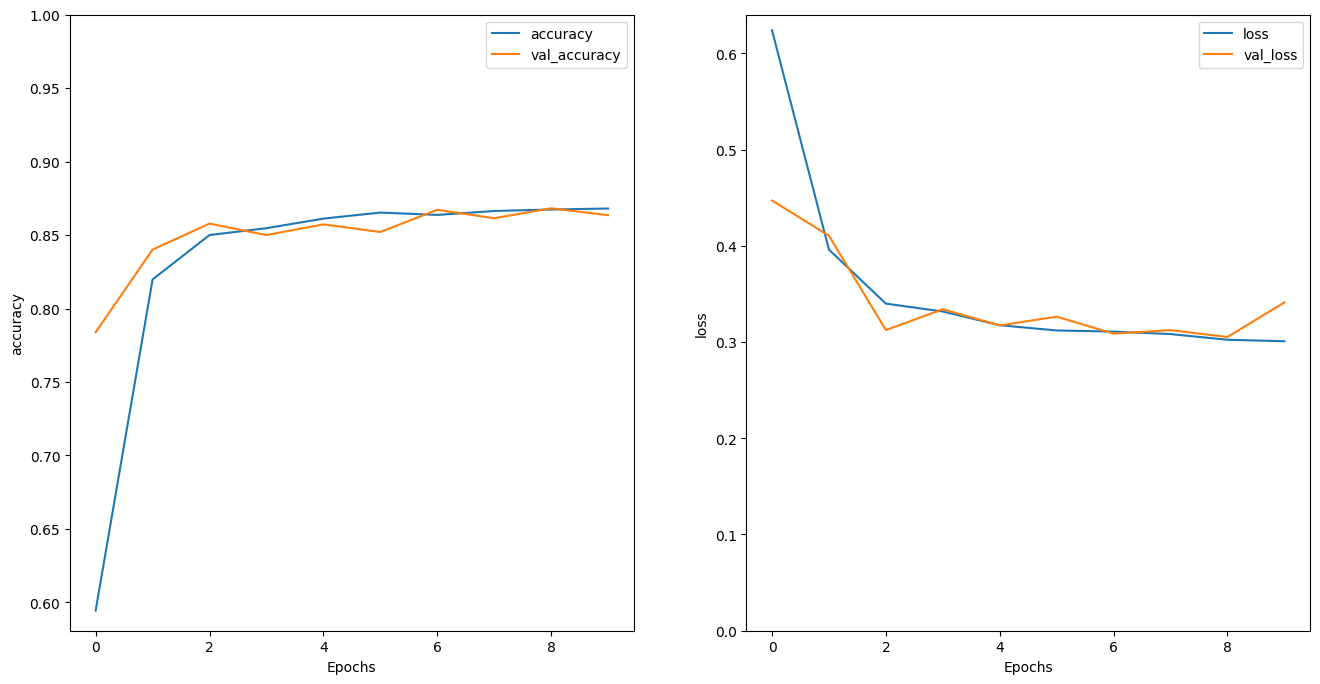

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
[0.6810179]


Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1375s 3s/step - accuracy: 0.5172 - loss: 0.6800 - val_accuracy: 0.7812 - val_loss: 0.4217
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1408s 4s/step - accuracy: 0.8135 - loss: 0.4002 - val_accuracy: 0.8406 - val_loss: 0.3358
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1406s 4s/step - accuracy: 0.8529 - loss: 0.3424 - val_accuracy: 0.7052 - val_loss: 0.4353
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1363s 3s/step - accuracy: 0.8351 - loss: 0.3608 - val_accuracy: 0.8479 - val_loss: 0.3333
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1418s 4s/step - accuracy: 0.8616 - loss: 0.3240 - val_accuracy: 0.8443 - val_loss: 0.3179
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1361s 3s/step - accuracy: 0.8647 - loss: 0.3098 - val_accuracy: 0.8615 - val_loss: 0.3254
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1416s 4s/step - accuracy: 0.8694 - loss: 0.3059 - val_accuracy: 0.8479 - val_loss: 0.3101
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1432s 4s/step - accuracy: 0.8671 - loss: 0.3058 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 286s 731ms/step - accuracy: 0.8440 - loss: 0.3202
Test Loss: 0.3199998736381531
Test Accuracy: 0.8432400226593018


In [ ]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-1.4616737]]


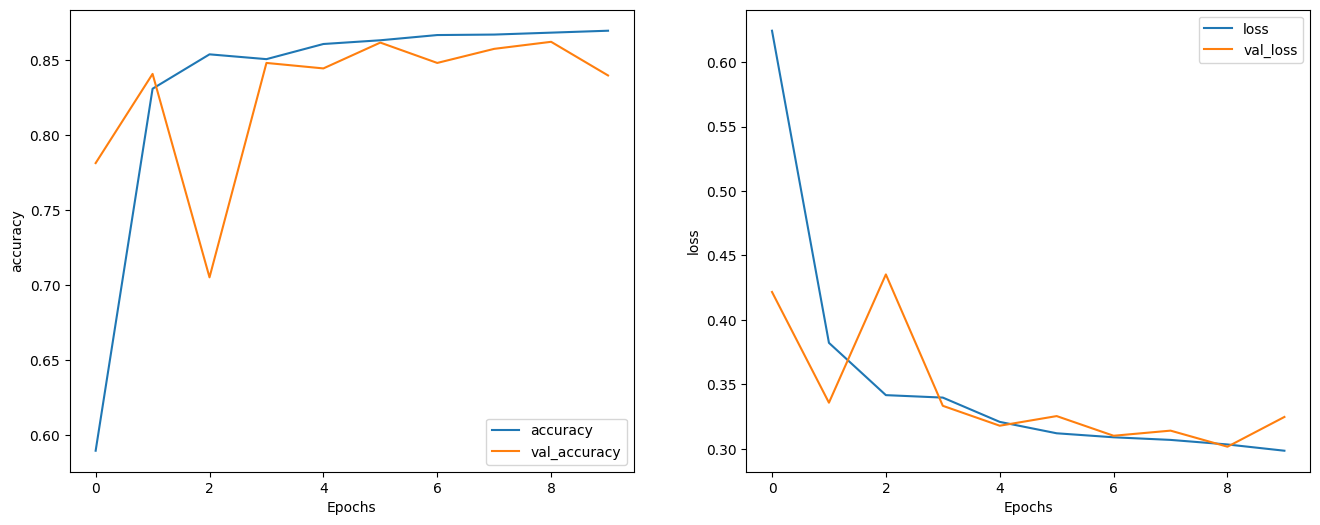

In [ ]:

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2

Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 64, 100), dtype=tf.int64, name=None))>

Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
import tensorflow as tf

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super(MyModel, self).__init__()  # Initialize the superclass without arguments
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

# Now create the model instance
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

Uji model

# Tugas
1.   Jalankan Model dan hitung loss dengan tf.
2.   Hitung update dan terapkan pada model dengan optimizer



In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

ValueError: in user code:

    File "<ipython-input-146-9e91cbfeabd9>", line 6, in train_step  *
        predictions = self(inputs, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-145-249fdc573934>", line 17, in call
        states = self.gru.get_initial_state(x[:, 0, :])

    ValueError: Exception encountered when calling CustomTraining.call().
    
    [1mIndex out of range using input dim 2; input has only 2 dims for '{{node custom_training_4_1/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=5, ellipsis_mask=0, end_mask=5, new_axis_mask=0, shrink_axis_mask=2](custom_training_4_1/embedding_7_1/GatherV2, custom_training_4_1/strided_slice/stack, custom_training_4_1/strided_slice/stack_1, custom_training_4_1/strided_slice/stack_2)' with input shapes: [100,256], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.[0m
    
    Arguments received by CustomTraining.call():
      • inputs=tf.Tensor(shape=(100,), dtype=int64)
      • states=None
      • return_state=False
      • training=True


In [ ]:
model.fit(dataset, epochs=1)

ValueError: in user code:

    File "<ipython-input-124-13b00a05429a>", line 6, in train_step  *
        predictions = self(inputs, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-119-47c3f0d45aa2>", line 11, in call
        x = self.rnn(x)

    ValueError: Exception encountered when calling CustomTraining.call().
    
    [1mInput 0 of layer "simple_rnn_2" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (64, 64, 100, 256)[0m
    
    Arguments received by CustomTraining.call():
      • inputs=tf.Tensor(shape=(64, 64, 100), dtype=int64)


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

# saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

AttributeError: 'Mean' object has no attribute 'reset_states'